In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import tensorflow_datasets as tfds  # For EuroSAT loading
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"urja2007","key":"0b43659003cd96e7f480e7504df8a523"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d apollo2506/eurosat-dataset

Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
License(s): CC0-1.0
 99% 2.02G/2.04G [00:19<00:00, 244MB/s]
100% 2.04G/2.04G [00:19<00:00, 111MB/s]


In [5]:
!unzip eurosat-dataset.zip -d eurosat_data

Streaming output truncated to the last 5000 lines.
  inflating: eurosat_data/EuroSATallBands/River/River_1990.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1991.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1992.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1993.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1994.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1995.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1996.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1997.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1998.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1999.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_2.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_20.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_200.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_2000.tif  
  inflating: eurosat_data/EuroSATallBands/Riv

In [13]:
import os
import json
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA


In [14]:
DATA_PATH = "/content/eurosat_data/EuroSATallBands"

train_df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_PATH, "validation.csv"))
test_df  = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

with open(os.path.join(DATA_PATH, "label_map.json")) as f:
    label_map = json.load(f)

inv_label_map = {v:k for k,v in label_map.items()}


In [15]:
def load_multiband_image(path):
    with rasterio.open(path) as src:
        img = src.read()  # (13, H, W)
    return img.astype(np.float32)


In [16]:
def plot_13_bands(img, title=""):
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    axes = axes.flatten()

    for i in range(13):
        axes[i].imshow(img[i], cmap='gray')
        axes[i].set_title(f"Band {i+1}")
        axes[i].axis('off')

    plt.suptitle(title)
    plt.show()


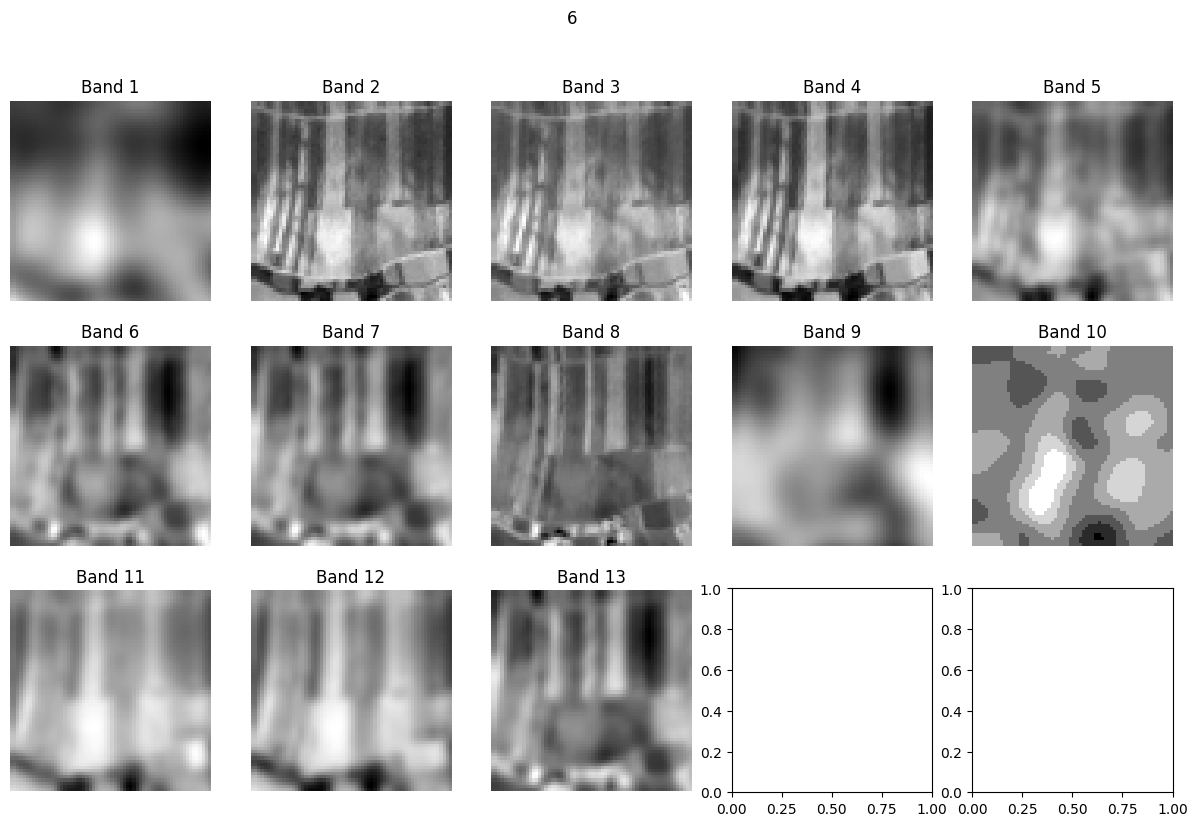

In [20]:
sample = train_df.iloc[0]
full_image_path = os.path.join(DATA_PATH, sample["Filename"])
img = load_multiband_image(full_image_path)
plot_13_bands(img, sample["Label"])

In [19]:
def compute_indices(img):
    B3 = img[2]   # Green
    B4 = img[3]   # Red
    B8 = img[7]   # NIR
    B11 = img[10] # SWIR

    ndvi = (B8 - B4) / (B8 + B4 + 1e-6)
    ndwi = (B3 - B8) / (B3 + B8 + 1e-6)
    ndbi = (B11 - B8) / (B11 + B8 + 1e-6)

    return ndvi, ndwi, ndbi


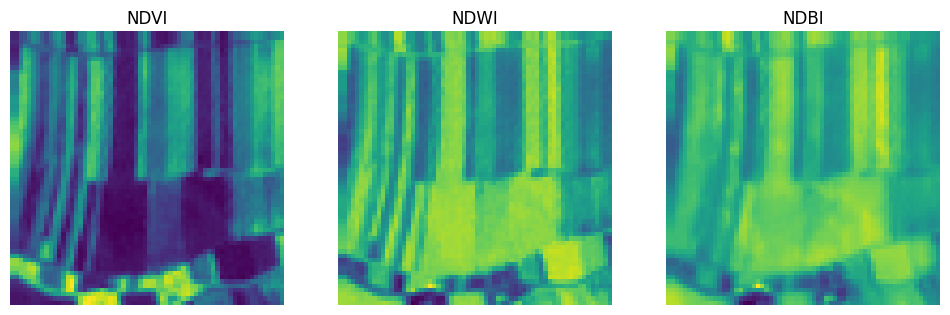

In [21]:
ndvi, ndwi, ndbi = compute_indices(img)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(ndvi); plt.title("NDVI"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(ndwi); plt.title("NDWI"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(ndbi); plt.title("NDBI"); plt.axis('off')
plt.show()


In [22]:
def extract_features(img):
    features = []

    # Raw band statistics
    for b in range(13):
        band = img[b]
        features.extend([
            band.mean(),
            band.std(),
            band.min(),
            band.max()
        ])

    # Spectral indices
    ndvi, ndwi, ndbi = compute_indices(img)
    for idx in [ndvi, ndwi, ndbi]:
        features.extend([
            idx.mean(),
            idx.std(),
            idx.min(),
            idx.max()
        ])

    return np.array(features)


In [24]:
print(train_df.columns)
train_df.head()


Index(['Filename', 'Label', 'ClassName'], dtype='object')


,Filename,Label,ClassName
0,PermanentCrop/PermanentCrop_2401.tif,6,PermanentCrop
1,PermanentCrop/PermanentCrop_1006.tif,6,PermanentCrop
2,HerbaceousVegetation/HerbaceousVegetation_1025...,2,HerbaceousVegetation
3,SeaLake/SeaLake_1439.tif,9,SeaLake
4,River/River_1052.tif,8,River


In [25]:
IMAGE_COL = "Filename"
LABEL_COL = "Label"      # already numeric
CLASS_COL = "ClassName"

In [26]:
img_path = os.path.join(DATA_PATH, row[IMAGE_COL])


In [27]:
print("Sample path:", img_path)
print("Image shape:", img.shape)

Sample path: /content/eurosat_data/EuroSATallBands/PermanentCrop/PermanentCrop_2401.tif
Image shape: (13, 64, 64)


In [28]:
X_train, y_train = [], []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img_path = os.path.join(DATA_PATH, row[IMAGE_COL])

    # Safety check
    if not os.path.exists(img_path):
        raise FileNotFoundError(img_path)

    img = load_multiband_image(img_path)
    feat = extract_features(img)

    X_train.append(feat)
    y_train.append(row[LABEL_COL])  # already integer

X_train = np.array(X_train)
y_train = np.array(y_train)



100%|██████████| 19317/19317 [01:43<00:00, 186.17it/s]


In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [31]:
ipca = IncrementalPCA(n_components=50, batch_size=256)
X_train_ipca = ipca.fit_transform(X_train_scaled)

In [33]:
explained_var = ipca.explained_variance_ratio_

print("Explained variance per PC:")
for i, v in enumerate(explained_var):
    print(f"PC{i+1}: {v:.4f}")

print("\nTotal explained variance:",
      explained_var.sum())

Explained variance per PC:
PC1: 0.3842
PC2: 0.1841
PC3: 0.1548
PC4: 0.0554
PC5: 0.0494
PC6: 0.0281
PC7: 0.0242
PC8: 0.0193
PC9: 0.0175
PC10: 0.0141
PC11: 0.0107
PC12: 0.0086
PC13: 0.0080
PC14: 0.0054
PC15: 0.0044
PC16: 0.0042
PC17: 0.0035
PC18: 0.0029
PC19: 0.0026
PC20: 0.0020
PC21: 0.0018
PC22: 0.0016
PC23: 0.0013
PC24: 0.0011
PC25: 0.0010
PC26: 0.0009
PC27: 0.0008
PC28: 0.0008
PC29: 0.0007
PC30: 0.0007
PC31: 0.0005
PC32: 0.0005
PC33: 0.0005
PC34: 0.0004
PC35: 0.0004
PC36: 0.0003
PC37: 0.0003
PC38: 0.0003
PC39: 0.0003
PC40: 0.0002
PC41: 0.0002
PC42: 0.0002
PC43: 0.0002
PC44: 0.0002
PC45: 0.0002
PC46: 0.0001
PC47: 0.0001
PC48: 0.0001
PC49: 0.0001
PC50: 0.0001

Total explained variance: 0.9994426391291034


In [36]:
import numpy as np

explained_var = ipca.explained_variance_ratio_

cumulative_var = np.cumsum(explained_var)

print("PC  | Explained Var | Cumulative Var")
print("------------------------------------")

for i in range(len(explained_var)):
    print(f"{i+1:>2}  | {explained_var[i]:.4f}        | {cumulative_var[i]:.4f}")

print("\nTotal cumulative explained variance:",
      cumulative_var[-1])


PC  | Explained Var | Cumulative Var
------------------------------------
 1  | 0.3842        | 0.3842
 2  | 0.1841        | 0.5683
 3  | 0.1548        | 0.7231
 4  | 0.0554        | 0.7785
 5  | 0.0494        | 0.8279
 6  | 0.0281        | 0.8559
 7  | 0.0242        | 0.8801
 8  | 0.0193        | 0.8994
 9  | 0.0175        | 0.9169
10  | 0.0141        | 0.9311
11  | 0.0107        | 0.9418
12  | 0.0086        | 0.9504
13  | 0.0080        | 0.9584
14  | 0.0054        | 0.9638
15  | 0.0044        | 0.9682
16  | 0.0042        | 0.9724
17  | 0.0035        | 0.9759
18  | 0.0029        | 0.9788
19  | 0.0026        | 0.9814
20  | 0.0020        | 0.9834
21  | 0.0018        | 0.9852
22  | 0.0016        | 0.9868
23  | 0.0013        | 0.9881
24  | 0.0011        | 0.9892
25  | 0.0010        | 0.9902
26  | 0.0009        | 0.9911
27  | 0.0008        | 0.9919
28  | 0.0008        | 0.9928
29  | 0.0007        | 0.9935
30  | 0.0007        | 0.9942
31  | 0.0005        | 0.9948
32  | 0.0005        | 0.995

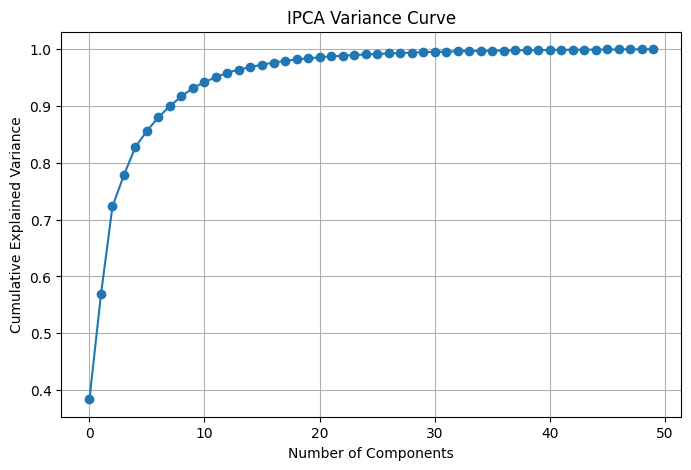

In [34]:
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_var), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("IPCA Variance Curve")
plt.grid()
plt.show()


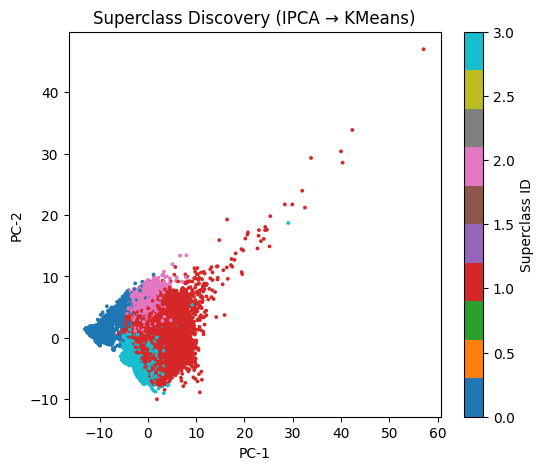

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca_vis = PCA(n_components=2)
X_2d = pca_vis.fit_transform(X_train_ipca)

# Map original class labels to superclass labels
y_super = np.array([class_to_super[cls] for cls in y_train])

plt.figure(figsize=(6,5))
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=y_super,
    cmap='tab10',
    s=3
)
plt.title("Superclass Discovery (IPCA → KMeans)")
plt.xlabel("PC-1")
plt.ylabel("PC-2")
plt.colorbar(label="Superclass ID")
plt.show()

In [51]:
from sklearn.decomposition import PCA

pca_vis_2 = PCA(n_components=2)
X_2d = pca_vis_2.fit_transform(X_train_ipca)

print("Explained variance of visualization PCs (2 PCs):")
for i, v in enumerate(pca_vis_2.explained_variance_ratio_):
    print(f"PC{i+1}: {v:.4f}")

print("Total variance (2 PCs):",
      pca_vis_2.explained_variance_ratio_.sum())


Explained variance of visualization PCs (2 PCs):
PC1: 0.3881
PC2: 0.1859
Total variance (2 PCs): 0.5739940565402004


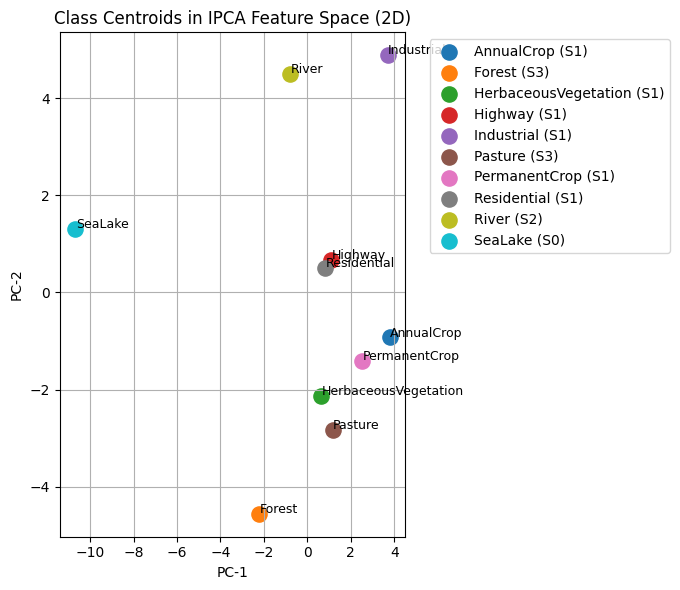

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA for visualization
pca_vis = PCA(n_components=2)
centroids_2d = pca_vis.fit_transform(class_centroids)

plt.figure(figsize=(7,6))

for i, cls in enumerate(unique_classes):
    super_id = class_to_super[cls]
    class_name = inv_label_map[cls]

    plt.scatter(
        centroids_2d[i, 0],
        centroids_2d[i, 1],
        s=120,
        label=f"{class_name} (S{super_id})"
    )

    # Label near point
    plt.text(
        centroids_2d[i, 0] + 0.02,
        centroids_2d[i, 1] + 0.02,
        class_name,
        fontsize=9
    )

plt.xlabel("PC-1")
plt.ylabel("PC-2")
plt.title("Class Centroids in IPCA Feature Space (2D)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


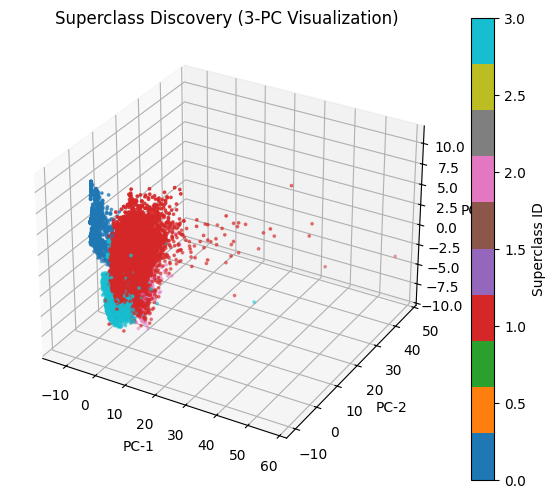

In [49]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # required for 3D

# PCA to 3 components (for visualization only)
pca_vis = PCA(n_components=3)
X_3d = pca_vis.fit_transform(X_train_ipca)

# Map class → superclass
y_super = np.array([class_to_super[cls] for cls in y_train])

# 3D Plot
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    X_3d[:, 0],
    X_3d[:, 1],
    X_3d[:, 2],
    c=y_super,
    cmap='tab10',
    s=3
)

ax.set_title("Superclass Discovery (3-PC Visualization)")
ax.set_xlabel("PC-1")
ax.set_ylabel("PC-2")
ax.set_zlabel("PC-3")

fig.colorbar(sc, ax=ax, label="Superclass ID")
plt.show()


In [50]:
print("Explained variance of visualization PCs:")
for i, v in enumerate(pca_vis.explained_variance_ratio_):
    print(f"PC{i+1}: {v:.4f}")

print("Total variance (3 PCs):",
      pca_vis.explained_variance_ratio_.sum())


Explained variance of visualization PCs:
PC1: 0.3881
PC2: 0.1859
PC3: 0.1563
Total variance (3 PCs): 0.7303068054982713


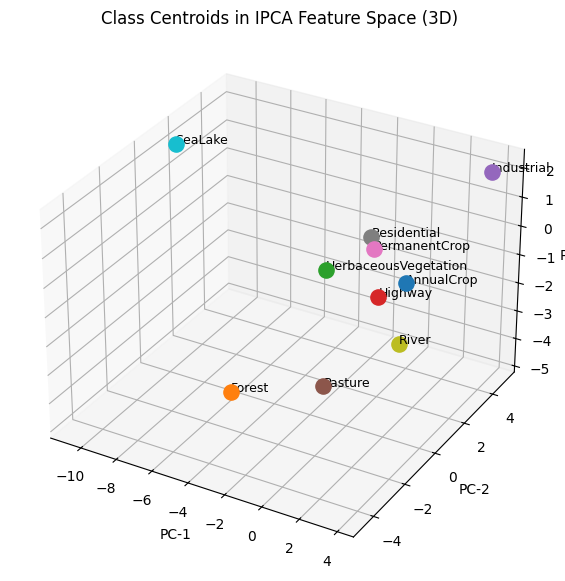

In [53]:
from mpl_toolkits.mplot3d import Axes3D

pca_vis_3 = PCA(n_components=3)
centroids_3d = pca_vis_3.fit_transform(class_centroids)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')

for i, cls in enumerate(unique_classes):
    super_id = class_to_super[cls]
    class_name = inv_label_map[cls]

    ax.scatter(
        centroids_3d[i, 0],
        centroids_3d[i, 1],
        centroids_3d[i, 2],
        s=120
    )

    ax.text(
        centroids_3d[i, 0],
        centroids_3d[i, 1],
        centroids_3d[i, 2],
        class_name,
        fontsize=9
    )

ax.set_title("Class Centroids in IPCA Feature Space (3D)")
ax.set_xlabel("PC-1")
ax.set_ylabel("PC-2")
ax.set_zlabel("PC-3")
plt.show()


In [39]:
import numpy as np

unique_classes = np.unique(y_train)
class_centroids = []
class_names = []

for cls in unique_classes:
    cls_feats = X_train_ipca[y_train == cls]
    centroid = cls_feats.mean(axis=0)

    class_centroids.append(centroid)
    class_names.append(cls)

class_centroids = np.array(class_centroids)


In [40]:
np.shape(class_centroids)

(10, 25)

In [41]:
from sklearn.cluster import KMeans

N_SUPER = 4

kmeans = KMeans(
    n_clusters=N_SUPER,
    random_state=42,
    n_init=20
)

super_labels = kmeans.fit_predict(class_centroids)


In [42]:
class_to_super = {
    cls: super_labels[i]
    for i, cls in enumerate(unique_classes)
}

print("Class → Superclass mapping:\n")
for cls, super_id in class_to_super.items():
    print(f"Class {cls} → Superclass {super_id}")


Class → Superclass mapping:

Class 0 → Superclass 1
Class 1 → Superclass 3
Class 2 → Superclass 1
Class 3 → Superclass 1
Class 4 → Superclass 1
Class 5 → Superclass 3
Class 6 → Superclass 1
Class 7 → Superclass 1
Class 8 → Superclass 2
Class 9 → Superclass 0


In [43]:
for cls, super_id in class_to_super.items():
    print(f"{cls} ({inv_label_map[cls]}) → Superclass {super_id}")


0 (AnnualCrop) → Superclass 1
1 (Forest) → Superclass 3
2 (HerbaceousVegetation) → Superclass 1
3 (Highway) → Superclass 1
4 (Industrial) → Superclass 1
5 (Pasture) → Superclass 3
6 (PermanentCrop) → Superclass 1
7 (Residential) → Superclass 1
8 (River) → Superclass 2
9 (SeaLake) → Superclass 0


In [48]:
from collections import defaultdict

super_to_classes = defaultdict(list)

for cls, super_id in class_to_super.items():
    class_name = inv_label_map[cls]
    super_to_classes[super_id].append(class_name)

print("Learned Superclass Hierarchy:\n")

for super_id in sorted(super_to_classes.keys()):
    print(f"Superclass {super_id}")
    for cls in super_to_classes[super_id]:
        print(f"  └── {cls}")
    print()



Learned Superclass Hierarchy:

Superclass 0
  └── SeaLake

Superclass 1
  └── AnnualCrop
  └── HerbaceousVegetation
  └── Highway
  └── Industrial
  └── PermanentCrop
  └── Residential

Superclass 2
  └── River

Superclass 3
  └── Forest
  └── Pasture



In [54]:
from sklearn.cluster import KMeans

def discover_superclasses(X_ipca, y, n_super):
    unique_classes = np.unique(y)
    centroids = []

    for cls in unique_classes:
        centroids.append(X_ipca[y == cls].mean(axis=0))

    centroids = np.array(centroids)

    kmeans = KMeans(n_clusters=n_super, random_state=42, n_init=20)
    super_labels = kmeans.fit_predict(centroids)

    return dict(zip(unique_classes, super_labels)), centroids


In [55]:
configs = [
    (10, 3),
    (15, 3),
    (25, 4),
    (40, 4),
    (25, 5),
]

results = {}

for n_pc, n_super in configs:
    print(f"\nIPCA={n_pc}, Superclasses={n_super}")

    ipca = IncrementalPCA(n_components=n_pc, batch_size=256)
    X_ipca = ipca.fit_transform(X_train_scaled)

    class_to_super, centroids = discover_superclasses(
        X_ipca, y_train, n_super
    )

    results[(n_pc, n_super)] = class_to_super
    print(class_to_super)



IPCA=10, Superclasses=3
{np.int64(0): np.int32(0), np.int64(1): np.int32(0), np.int64(2): np.int32(0), np.int64(3): np.int32(0), np.int64(4): np.int32(2), np.int64(5): np.int32(0), np.int64(6): np.int32(0), np.int64(7): np.int32(0), np.int64(8): np.int32(2), np.int64(9): np.int32(1)}

IPCA=15, Superclasses=3
{np.int64(0): np.int32(0), np.int64(1): np.int32(0), np.int64(2): np.int32(0), np.int64(3): np.int32(0), np.int64(4): np.int32(2), np.int64(5): np.int32(0), np.int64(6): np.int32(0), np.int64(7): np.int32(0), np.int64(8): np.int32(2), np.int64(9): np.int32(1)}

IPCA=25, Superclasses=4
{np.int64(0): np.int32(1), np.int64(1): np.int32(3), np.int64(2): np.int32(1), np.int64(3): np.int32(1), np.int64(4): np.int32(1), np.int64(5): np.int32(3), np.int64(6): np.int32(1), np.int64(7): np.int32(1), np.int64(8): np.int32(2), np.int64(9): np.int32(0)}

IPCA=40, Superclasses=4
{np.int64(0): np.int32(1), np.int64(1): np.int32(3), np.int64(2): np.int32(1), np.int64(3): np.int32(1), np.int64(4):

In [56]:
from sklearn.metrics import silhouette_score

score = silhouette_score(centroids, list(class_to_super.values()))
print("Silhouette score:", score)


Silhouette score: 0.21496955445001475


In [57]:
from sklearn.cluster import AgglomerativeClustering


In [58]:
agglo = AgglomerativeClustering(
    n_clusters=4,
    linkage="ward"   # best for Euclidean / PCA space
)

super_labels_agg = agglo.fit_predict(class_centroids)

# Build mapping
class_to_super_agg = {
    cls: super_labels_agg[i]
    for i, cls in enumerate(unique_classes)
}

print("Agglomerative Superclass Mapping:\n")
for cls, sid in class_to_super_agg.items():
    print(f"{inv_label_map[cls]} → Superclass {sid}")


Agglomerative Superclass Mapping:

AnnualCrop → Superclass 0
Forest → Superclass 1
HerbaceousVegetation → Superclass 0
Highway → Superclass 0
Industrial → Superclass 0
Pasture → Superclass 1
PermanentCrop → Superclass 0
Residential → Superclass 0
River → Superclass 2
SeaLake → Superclass 3


In [59]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt


In [60]:
Z = linkage(
    class_centroids,
    method="ward"
)


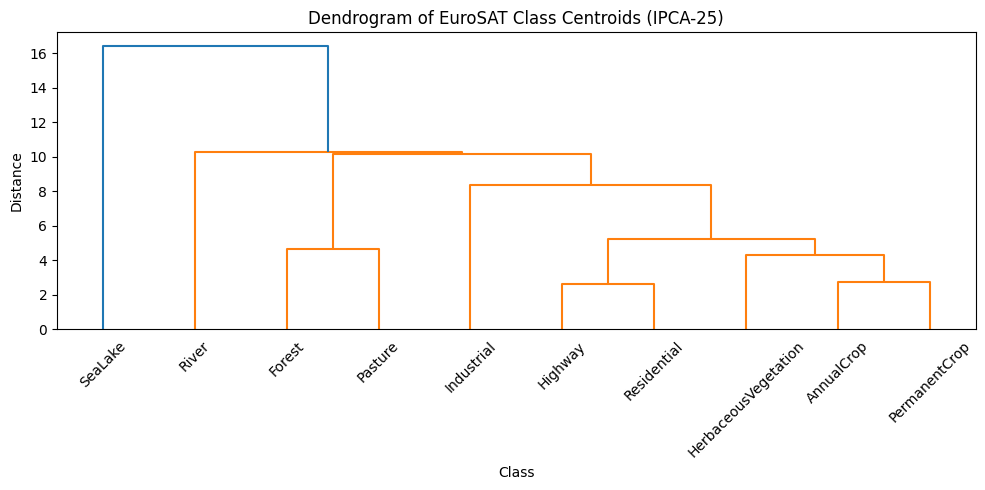

In [61]:
plt.figure(figsize=(10, 5))

dendrogram(
    Z,
    labels=[inv_label_map[c] for c in unique_classes],
    leaf_rotation=45,
    leaf_font_size=10
)

plt.title("Dendrogram of EuroSAT Class Centroids (IPCA-25)")
plt.xlabel("Class")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [62]:
from sklearn.decomposition import PCA

pca_vis = PCA(n_components=2)
centroids_2d = pca_vis.fit_transform(class_centroids)


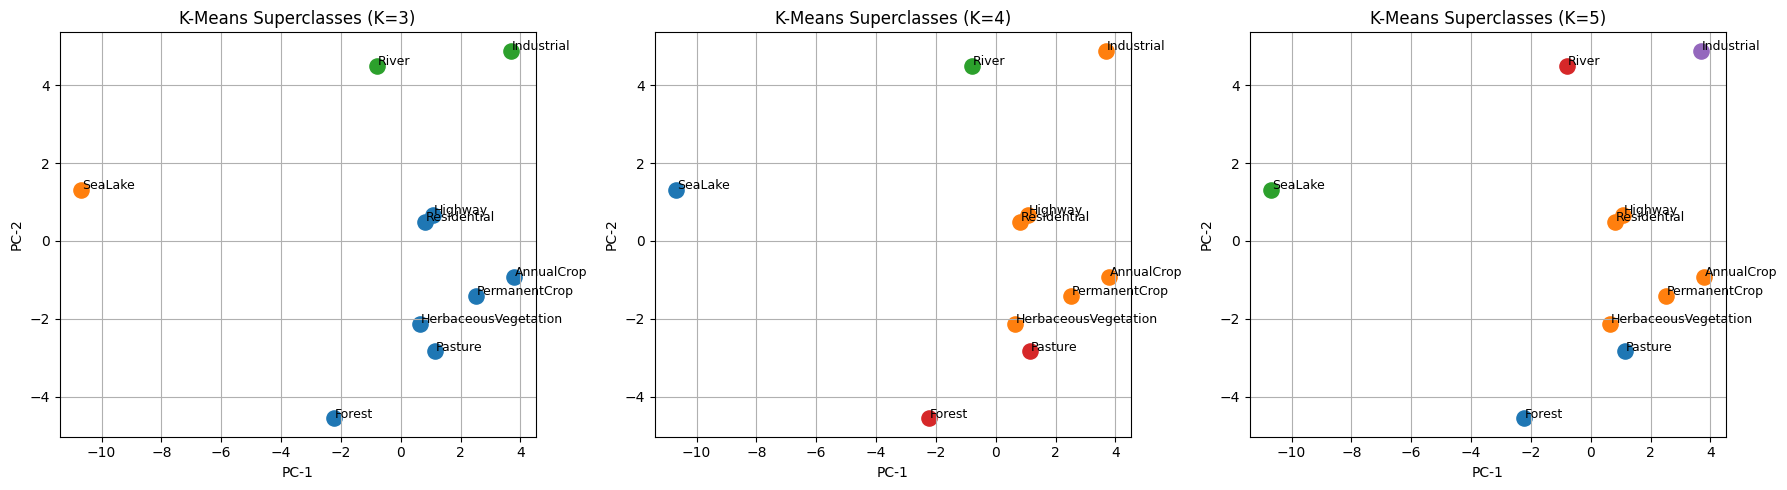

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, K in zip(axes, [3, 4, 5]):
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=20)
    labels = kmeans.fit_predict(class_centroids)

    for i, cls in enumerate(unique_classes):
        ax.scatter(
            centroids_2d[i, 0],
            centroids_2d[i, 1],
            s=120,
            c=f"C{labels[i]}"
        )
        ax.text(
            centroids_2d[i, 0] + 0.02,
            centroids_2d[i, 1] + 0.02,
            inv_label_map[cls],
            fontsize=9
        )

    ax.set_title(f"K-Means Superclasses (K={K})")
    ax.set_xlabel("PC-1")
    ax.set_ylabel("PC-2")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.decomposition import PCA

pca_vis = PCA(n_components=3)
centroids_2d = pca_vis.fit_transform(class_centroids)

In [64]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


In [65]:
Ks = [3, 4, 5]

print("=== CLUSTERING COMPARISON (Class Centroids, IPCA-25) ===\n")

for K in Ks:
    print(f"K = {K}")

    # ---------- K-MEANS ----------
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=20)
    km_labels = kmeans.fit_predict(class_centroids)

    km_sil = silhouette_score(class_centroids, km_labels)
    km_db  = davies_bouldin_score(class_centroids, km_labels)
    km_ch  = calinski_harabasz_score(class_centroids, km_labels)

    # ---------- AGGLOMERATIVE ----------
    agg = AgglomerativeClustering(n_clusters=K, linkage="ward")
    ag_labels = agg.fit_predict(class_centroids)

    ag_sil = silhouette_score(class_centroids, ag_labels)
    ag_db  = davies_bouldin_score(class_centroids, ag_labels)
    ag_ch  = calinski_harabasz_score(class_centroids, ag_labels)

    print(f"  K-Means       → Sil={km_sil:.3f}, DB={km_db:.3f}, CH={km_ch:.1f}")
    print(f"  Agglomerative → Sil={ag_sil:.3f}, DB={ag_db:.3f}, CH={ag_ch:.1f}")
    print()


=== CLUSTERING COMPARISON (Class Centroids, IPCA-25) ===

K = 3
  K-Means       → Sil=0.272, DB=0.890, CH=6.0
  Agglomerative → Sil=0.269, DB=0.413, CH=5.1

K = 4
  K-Means       → Sil=0.207, DB=0.622, CH=6.3
  Agglomerative → Sil=0.207, DB=0.622, CH=6.3

K = 5
  K-Means       → Sil=0.215, DB=0.543, CH=8.3
  Agglomerative → Sil=0.215, DB=0.543, CH=8.3



In [66]:
from sklearn.decomposition import PCA
import numpy as np

def get_centroids_for_pc(X_ipca, y, n_pc):
    """
    X_ipca : (N_images, 25)  ← already IPCA(25)
    y      : class labels
    n_pc   : 2, 3, or 50 (if <=25, PCA; if >25, use original features)
    """

    if n_pc <= X_ipca.shape[1]:
        pca = PCA(n_components=n_pc)
        X_proj = pca.fit_transform(X_ipca)
    else:
        raise ValueError("PC > IPCA dimension not allowed here")

    unique_classes = np.unique(y)
    centroids = []

    for cls in unique_classes:
        centroids.append(X_proj[y == cls].mean(axis=0))

    return np.array(centroids)


In [69]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

def compare_clustering(centroids_data):
    Ks = [3, 4, 5]
    results = {}
    for K in Ks:
        # K-MEANS
        kmeans = KMeans(n_clusters=K, random_state=42, n_init=20)
        km_labels = kmeans.fit_predict(centroids_data)
        km_sil = silhouette_score(centroids_data, km_labels)
        km_db  = davies_bouldin_score(centroids_data, km_labels)
        km_ch  = calinski_harabasz_score(centroids_data, km_labels)

        # AGGLOMERATIVE
        agg = AgglomerativeClustering(n_clusters=K, linkage="ward")
        ag_labels = agg.fit_predict(centroids_data)
        ag_sil = silhouette_score(centroids_data, ag_labels)
        ag_db  = davies_bouldin_score(centroids_data, ag_labels)
        ag_ch  = calinski_harabasz_score(centroids_data, ag_labels)

        results[K] = {
            "kmeans": {"Sil": km_sil, "DB": km_db, "CH": km_ch},
            "agglo":  {"Sil": ag_sil, "DB": ag_db, "CH": ag_ch}
        }
    return results

centroids_pc2 = get_centroids_for_pc(X_train_ipca, y_train, n_pc=2)
results_pc2 = compare_clustering(centroids_pc2)

print("=== PC = 2 ===")
for K, r in results_pc2.items():
    print(f"K={K}")
    print("  KMeans :", r["kmeans"])
    print("  Agglo  :", r["agglo"])

=== PC = 2 ===
K=3
  KMeans : {'Sil': np.float64(0.4326435975605392), 'DB': np.float64(0.5278153978443433), 'CH': np.float64(13.347763175106493)}
  Agglo  : {'Sil': np.float64(0.4326435975605392), 'DB': np.float64(0.5278153978443432), 'CH': np.float64(13.347763175106493)}
K=4
  KMeans : {'Sil': np.float64(0.33793111436642326), 'DB': np.float64(0.47136088222819994), 'CH': np.float64(14.345722626312487)}
  Agglo  : {'Sil': np.float64(0.33793111436642326), 'DB': np.float64(0.47136088222819994), 'CH': np.float64(14.345722626312487)}
K=5
  KMeans : {'Sil': np.float64(0.27496612104545903), 'DB': np.float64(0.2666644087114375), 'CH': np.float64(15.82453993120709)}
  Agglo  : {'Sil': np.float64(0.27496612104545903), 'DB': np.float64(0.26666440871143754), 'CH': np.float64(15.82453993120709)}


In [71]:
centroids_pc3 = get_centroids_for_pc(X_train_ipca, y_train, n_pc=3)
results_pc3 = compare_clustering(centroids_pc3)

print("\n=== PC = 3 ===")
for K, r in results_pc3.items():
    print(f"K={K}")
    print("  KMeans :", r["kmeans"])
    print("  Agglo  :", r["agglo"])


=== PC = 3 ===
K=3
  KMeans : {'Sil': np.float64(0.32736643598760085), 'DB': np.float64(0.7596447101452725), 'CH': np.float64(7.923547523767613)}
  Agglo  : {'Sil': np.float64(0.32736643598760085), 'DB': np.float64(0.7596447101452725), 'CH': np.float64(7.923547523767613)}
K=4
  KMeans : {'Sil': np.float64(0.24230769952193412), 'DB': np.float64(0.5381248767814741), 'CH': np.float64(8.160050700956822)}
  Agglo  : {'Sil': np.float64(0.25946842220713445), 'DB': np.float64(0.739971955368292), 'CH': np.float64(8.718469198480303)}
K=5
  KMeans : {'Sil': np.float64(0.26340745639450763), 'DB': np.float64(0.46015590049685906), 'CH': np.float64(12.313679768604567)}
  Agglo  : {'Sil': np.float64(0.26340745639450763), 'DB': np.float64(0.46015590049685906), 'CH': np.float64(12.313679768604567)}


In [ ]:
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import numpy as np

# Step 1: Check your IPCA features
print("X_train_ipca shape:", X_train_ipca.shape)

# Step 2: Choose n_pc = 25 (the actual number of features in X_train_ipca)
n_pc = X_train_ipca.shape[1] # Set n_pc to the actual number of components
if X_train_ipca.shape[1] < n_pc:
    raise ValueError(f"X_train_ipca only has {X_train_ipca.shape[1]} features. Can't use {n_pc} PCs.")

# Step 3: Get centroids per class
def get_centroids_for_pc(features, labels, n_pc):
    unique_labels = np.unique(labels)
    centroids = []
    for lbl in unique_labels:
        # Take mean along n_pc components
        centroids.append(features[labels == lbl, :n_pc].mean(axis=0))
    return np.stack(centroids)

centroids_pc50 = get_centroids_for_pc(X_train_ipca, y_train, n_pc=n_pc)

# Step 4: Compare clustering
def compare_clustering(centroids, K_values=[2,3,4,5]):
    results = {}
    for K in K_values:
        kmeans = KMeans(n_clusters=K, random_state=42, n_init=20).fit(centroids)
        agglo = AgglomerativeClustering(n_clusters=K).fit(centroids)
        results[K] = {"kmeans": kmeans.labels_, "agglo": agglo.labels_}
    return results

results_pc50 = compare_clustering(centroids_pc50)

# Step 5: Print results
print(f"\n=== PC = {n_pc} ===")
for K, r in results_pc50.items():
    print(f"K={K}")
    print("  KMeans :", r["kmeans"])
    print("  Agglo  :", r["agglo"])
